# Deep Dive of Setter Performance

by `Xiaoli Qiu`

created: `2021-12-09`

JIRA: https://clearlink.atlassian.net/browse/ONE-8654; https://clearlink.atlassian.net/browse/ONE-8100; https://clearlink.atlassian.net/browse/ONE-7845, orginal ticket: https://clearlink.atlassian.net/browse/ONE-7706.

This notebook gauges the performance of the Setter team during 2021 AEP (Nov 9 - Dec 7th). 

<div class="alert alert-block alert-info"> <b>NOTE: </b> Medicare data is very messy, same customer could have multiple lead_id's. To address this problem, only certain customers are included in this analysis, being (1) the new customers, meaning, the ANI (phone number) that doeas not have a lead_id created before the project start date (Nov 9th, 2021). (2) the customers with a valid lead_id (i.e., a lead_id could be found). </div>

<div class="alert alert-block alert-warning"> <b>Important Note: </b> there is no perfect way to approach this analysis due to many data quality problems. </div>

__Timeline:__ <br>
Nov 9, 2021: project started, 3 Setter agents <br>
Nov 15, 2021: added 6 more agents to the Setter team <br>
Dec 2, 2021: added 7 more agents to the Setter team (essentially only 4 agent, as 3 of the 7 agents only worked for 1 day on Dec 2nd) <br>

<br>
<br>

For the __financial analysis__, the costs and revenue structure are as follows: 

The costs included are the following: for non-Manila agents (temp agents): rep wage (17.9/HR), bonus per policy (6.1), commission per policy (40). Rep wage of 5/h for Manila agents. For the sold policies, CPA cost (450) is also included.


The revenue estimates below are provided by @BryceDachtler. These are November's estimates based on October averages, Bryce uses these to estimate pace revenue for placemate (November Month end revenue). <br>

MA/MAPD - 1270 <br>
MedSupp - 1000 <br>
DSNP - 950 <br>
PDP - 165 <br>
Ancillary - 100 <br>

<br>

For the __issue rate__ calculation, the [Google Sheet](https://docs.google.com/spreadsheets/d/1p9zC5YxAsaJcFjRetIEDmRI_RT_WKjJgZ_wv15JV-v4/edit#gid=0) by @DamonJones is used. The following statuses are considered as 'issued': <br>

| ID  | Policy Status                 | Revenue Eligible | AIM Group | Issue Rate Group | Active |
| --- | ----------------------------- | ---------------- | --------- | ---------------- | ------ |
| 1   | Agent Signature               | 1                |           | Invalid          | 0      |
| 2   | CS Review                     | 1                |           | Group not mapped | 0      |
| 3   | Error Correction              | 1                | temporary | Error Correction | 1      |
| 4   | Received by Carrier           | 1                | temporary | Group not mapped | 1      |
| 6   | CMS Review                    | 1                | temporary | Group not mapped | 1      |
| 7   | Additional Info Requested     | 1                | temporary | Group not mapped | 1      |
| 8   | Awaiting Beneficiary Response | 1                |           | Group not mapped | 0      |
| 9   | Enrolled - Awaiting Payment   | 1                | temporary | Approved         | 1      |
| 14  | Approved                      | 1                | final     | Approved         | 1      |
| 21  | Carrier Follow Up             | 1                | temporary | Group not mapped | 1      |
| 22  | Carrier Approved              | 1                | final     | Approved         | 1      |
| 23  | Final Approved                | 1                |           | Approved         | 0      |
| 25  | Rewrite Requested             | 1                | temporary | Invalid          | 1      |
| 27  | Manual Review                 | 1                | temporary | Error Correction | 1      |


<br>

## Contents
- [Previsouly Uncounted Agents](#wrong_setter_attri)
1. <a href='#data_processing'> Data Processing </a>
2. <a href='#aht'> AHT </a>
3. <a href='#cpl'> Cost per Lead </a>
4. <a href='#conv'> Conversion </a>
5. <a href='#issue_rate'> Issue Rate </a>
6. <a href='#gppc'> GPPC & GP Lift </a>
7. <a href='#same_setter_costs'> Assuming Same Agent Costs for Setter Team </a>

In [128]:
import datetime
print('Last time updated: ', datetime.datetime.now())

Last time updated:  2022-03-15 12:38:21.752093


In [2]:
import pandas as pd
import numpy as np 

In [3]:
import seaborn as sns

import plotly.express as px
import plotly.io as pio

%matplotlib inline

In [4]:
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()

In [5]:
#style definition
sns.set_theme(style="darkgrid")
sns.set_palette("hls")
# sns.set_style("whitegrid")
import matplotlib.pyplot as plt  
plt.style.use('dark_background')

pio.templates.default = "plotly_dark"

In [6]:
# Set universal font size
plt.rcParams.update({'font.size': 20})

In [8]:
# import psycopg2

In [9]:
# con = psycopg2.connect(dbname = 'datawarehouse', host ='dw_prod.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)

# con = psycopg2.connect(dbname = 'datawarehouse_stage', host ='dw_stage.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)

In [10]:
get_raw_data = """
DROP TABLE IF EXISTS ani_1st_lead;
CREATE TEMP TABLE ani_1st_lead AS(
SELECT coalesce(ani, phone) AS ani_n, id,
       convert_timezone('America/Denver', created_at) AS lead_created,
       convert_timezone('America/Denver', updated_at) AS lead_updated,
       ROW_NUMBER() over (PARTITION BY ani_n ORDER BY created_at) AS row_n
FROM ins_aim_db.leads_leads);

-- All customers/ANIs whose lead_id was created after Nov 9 2021 have been retrived.
DROP TABLE IF EXISTS ani_lead_launch;
CREATE TABLE ani_lead_launch AS(
SELECT *
FROM ani_1st_lead
WHERE row_n = 1
AND DATE(lead_created) >= '2021-11-09');


SELECT date_sort_prequeue_start  AS DATE,
       cd.contact_id,
       cd.ani,
       cd.skill,
       cd.skill_name,
       cd.call_conclusion,
       cd.abandon_code_name,
       cd.date_call_start,
       cd.date_call_end,
       cd.handle_time,
       u.id AS user_id,
       cd.cd_agent_id, 
       u.andana_username,
       u.title,
       uh.team,
       uh.facility,
       ll.id AS lead_id,
       ll.lead_created,
       ll.lead_updated,
       ma.id AS applicant_id,
       map.id AS policy_id,
       map.sales_type AS policy_type,
       convert_timezone('America/Denver', map.created_at) AS policy_date,
       convert_timezone('America/Denver', map.deleted_at) AS policy_deleted,
       map2.product_type
FROM data_warehouse.call_detail cd
         LEFT JOIN data_warehouse.users_history uh ON uh.id = cd.users_history_id
         LEFT JOIN data_warehouse.users u ON u.id = uh.users_id
         RIGHT JOIN ani_lead_launch ll
                   ON cd.ani = ll.ani_n
                       AND cd.date_sort_prequeue_start = DATE(ll.lead_created)
         LEFT JOIN ins_aim_db.medicare_applicants ma ON ll.id = ma.leads_lead_id
         LEFT JOIN ins_aim_db.medicare_app_policies map ON ma.id = map.applicant_id
                        AND convert_timezone('America/Denver', map.created_at) > ll.lead_created
         LEFT JOIN ins_aim_db.medicare_app_plans map2 ON map2.id = map.app_plan_id
WHERE 1 = 1
  AND date_sort_prequeue_start BETWEEN '2021-11-09' AND '2021-12-07'
AND ll.id IS NOT NULL
AND ((cd.skill IN (8410920) AND call_conclusion = 'Answered') OR (cd.skill IN (10705109)))
ORDER BY 1, 3, 2;
"""

In [11]:
# df = pd.read_sql_query(get_raw_data, con)

In [12]:
# df.to_pickle('SetterPreformace_2021AEP_retrieved_20220301.pkl')

In [7]:
df = pd.read_pickle('SetterPreformace_2021AEP_retrieved_20220301.pkl')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41823 entries, 0 to 41822
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               41823 non-null  object        
 1   contact_id         41823 non-null  int64         
 2   ani                41823 non-null  int64         
 3   skill              41823 non-null  int64         
 4   skill_name         41823 non-null  object        
 5   call_conclusion    41823 non-null  object        
 6   abandon_code_name  41823 non-null  object        
 7   date_call_start    41823 non-null  datetime64[ns]
 8   date_call_end      41823 non-null  datetime64[ns]
 9   handle_time        41823 non-null  int64         
 10  user_id            41515 non-null  float64       
 11  cd_agent_id        41823 non-null  int64         
 12  andana_username    41515 non-null  object        
 13  title              41515 non-null  object        
 14  team  

In [9]:
df['ani'].nunique() == df['lead_id'].nunique()

True

Validated that each customer (`ani`) has a valid `lead_id`.

<a id='wrong_setter_attri'> </a>
## The Setter Agents Moved on 2021-12-02

In [10]:
# These were the agents that were moved to the Setter team on Dec 2nd 2021
df[df['cd_agent_id'].isin([19638128, 19638129, 19638130, 19638131, 19637146, 19635461, 19477027])]['cd_agent_id'].value_counts()

19638131    218
19638130    190
19638129    142
19638128    101
19635461     50
19637146      9
19477027      9
Name: cd_agent_id, dtype: int64

In [11]:
# Change their team and title accordingly
df[df['cd_agent_id'].isin([19638128, 19638129, 19638130, 19638131, 19637146, 19635461, 19477027])].groupby(['cd_agent_id']).agg({'facility': lambda x:x.unique(), 
                                                                                                                                 'team': lambda x:x.unique(), 
                                                                                                                                 'title': lambda x:x.unique(), 
                                                                                                                                 'contact_id': lambda x:x.nunique(), 
                                                                                                                                 'date_call_start': 'min', 
                                                                                                                                 'date_call_end': 'max'}).reset_index().sort_values(by=['cd_agent_id'])

cd_agent_id facility                                  team  \
0     19477027     None                                  None   
1     19635461     None                                  None   
2     19637146     None                                  None   
3     19638128   Manila                          ATT Mobility   
4     19638129   Manila  [Insurance Allocation, ATT Mobility]   
5     19638130   Manila  [Insurance Allocation, ATT Mobility]   
6     19638131   Manila  [Insurance Allocation, ATT Mobility]   

             title  contact_id     date_call_start       date_call_end  
0             None           9 2021-12-02 14:59:03 2021-12-02 16:02:56  
1             None          50 2021-12-02 15:08:51 2021-12-07 13:00:09  
2             None           9 2021-12-02 15:16:51 2021-12-02 16:00:35  
3  Sales Executive         101 2021-12-06 09:06:31 2021-12-07 15:40:39  
4  Sales Executive         142 2021-12-03 07:30:32 2021-12-06 15:49:57  
5  Sales Executive         190 2021-12-03 07:36:21 2021-12-07 15:38:14  
6  Sales Executive         217 2021-12-03 07:55:27 2021-12-07 15:55:08

In [12]:
# It seems all of them are Manila agents, change their facility, team, title accrodingly
agents_list_tbc = [19638128, 19638129, 19638130, 19638131, 19637146, 19635461, 19477027]
df.loc[df['cd_agent_id'].isin(agents_list_tbc), 'facility'] = 'Manila'  
df.loc[df['cd_agent_id'].isin(agents_list_tbc), 'team'] = 'Insurance Allocation'  
df.loc[df['cd_agent_id'].isin(agents_list_tbc), 'title'] = 'Lead Generation'  


In [13]:
# Double-check if the changes were made correctly
df[df['cd_agent_id'].isin(agents_list_tbc)].groupby(['cd_agent_id']).agg({'facility': lambda x:x.unique(), 
                                                                          'team': lambda x:x.unique(), 
                                                                          'title': lambda x:x.unique(), 
                                                                          'contact_id': lambda x:x.nunique(), 
                                                                          'date_call_start': 'min', 
                                                                          'date_call_end': 'max'}).reset_index().sort_values(by=['cd_agent_id'])

cd_agent_id facility                  team            title  contact_id  \
0     19477027   Manila  Insurance Allocation  Lead Generation           9   
1     19635461   Manila  Insurance Allocation  Lead Generation          50   
2     19637146   Manila  Insurance Allocation  Lead Generation           9   
3     19638128   Manila  Insurance Allocation  Lead Generation         101   
4     19638129   Manila  Insurance Allocation  Lead Generation         142   
5     19638130   Manila  Insurance Allocation  Lead Generation         190   
6     19638131   Manila  Insurance Allocation  Lead Generation         217   

      date_call_start       date_call_end  
0 2021-12-02 14:59:03 2021-12-02 16:02:56  
1 2021-12-02 15:08:51 2021-12-07 13:00:09  
2 2021-12-02 15:16:51 2021-12-02 16:00:35  
3 2021-12-06 09:06:31 2021-12-07 15:40:39  
4 2021-12-03 07:30:32 2021-12-06 15:49:57  
5 2021-12-03 07:36:21 2021-12-07 15:38:14  
6 2021-12-03 07:55:27 2021-12-07 15:55:08

## Latest Status Update for Each Policy

In [14]:
# Get the latest status update for each policy
policy_ids = df['policy_id'].dropna().unique()
policy_ids_list = policy_ids.tolist()
policy_ids_list = [int(x) for x in policy_ids_list]
policy_ids_s = "({policy_id})".format(policy_id=', '.join(map(str, ["{x}".format(x=x) for x in policy_ids_list])))

In [21]:
get_policy_latest_status = """
SELECT mas.app_policy_id AS policy_id, date(map.created_at) as sales_date, date(imp.effective_date) as effective_date,
       date(mas.created_at) AS last_update, mas.status_id, ms.label, rev.revenue_eligible
FROM ( SELECT DISTINCT mas.app_policy_id as id,
                MAX(mas.created_at) as time_stamp
      FROM ins_aim_db.medicare_app_statuses mas
      WHERE mas.app_policy_id IN {policy_ids_s}
      GROUP BY 1) as last_stamp
JOIN ins_aim_db.medicare_app_statuses mas ON last_stamp.id = mas.app_policy_id AND last_stamp.time_stamp = mas.created_at
JOIN ins_aim_db.medicare_statuses ms ON mas.status_id = ms.id
join ins_aim_db.medicare_app_policies map ON mas.app_policy_id = map.id
JOIN data_warehouse.insurance_medicare_policies imp ON last_stamp.id = imp.policy_id
LEFT JOIN data_warehouse.ins_policy_rev_eligibility rev ON rev.id = ms.id;
"""

In [22]:
# df_policy_status_latest = pd.read_sql_query(get_policy_latest_status.format(policy_ids_s=policy_ids_s), con)

In [15]:
# df_policy_status_latest.to_pickle('policy_status_latest_retrieved_20220301.pkl')
df_policy_status_latest = pd.read_pickle('policy_status_latest_retrieved_20220301.pkl')

In [16]:
df_policy_status_latest

policy_id  sales_date effective_date last_update  status_id  \
0         68161  2021-11-27     2022-01-01  2021-11-29         13   
1         67909  2021-11-26     2022-01-01  2021-11-29         14   
2         68431  2021-11-29     2022-01-01  2021-11-29          4   
3         69768  2021-12-03     2022-01-01  2021-12-06         14   
4         69538  2021-12-02     2022-01-01  2021-12-06         14   
...         ...         ...            ...         ...        ...   
3385      68273  2021-11-28     2022-01-01  2021-12-02         14   
3386      68080  2021-11-27     2022-01-01  2021-12-02         14   
3387      68047  2021-11-27     2022-01-01  2021-12-02         14   
3388      67912  2021-11-26     2022-01-01  2021-12-02         14   
3389      68035  2021-11-27     2022-01-01  2021-12-02         14   

                    label  revenue_eligible  
0               Withdrawn                 0  
1                Approved                 1  
2     Received by Carrier                 1  
3                Approved                 1  
4                Approved                 1  
...                   ...               ...  
3385             Approved                 1  
3386             Approved                 1  
3387             Approved                 1  
3388             Approved                 1  
3389             Approved                 1  

[3390 rows x 7 columns]

In [17]:
df_policy_status_latest['effective_date'].min()

datetime.date(2021, 11, 27)

In [18]:
df_policy_status_latest['effective_date'].max()

datetime.date(2022, 3, 6)

In [19]:
# There are policies sold after AEP  - > not included in the plots below
df['policy_date'].dt.date.unique()[-10:]

array([datetime.date(2022, 1, 24), datetime.date(2022, 1, 10),
       datetime.date(2021, 12, 14), datetime.date(2022, 2, 17),
       datetime.date(2022, 1, 28), datetime.date(2022, 2, 11),
       datetime.date(2022, 2, 24), datetime.date(2022, 2, 23),
       datetime.date(2022, 2, 25), datetime.date(2021, 12, 13)],
      dtype=object)

<a id='pre_process'>  </a>

#  Preprocessing 

In [20]:
def pre_process(df): 
    """
    Adding lead origination, call origination, revenue values, costs, order of calls
    :param df: dataframe to be processed
    :return: processed dataframe with all the information added
    """
    # revenue
    df['revenue'] = 0
    df.loc[df['product_type'].isin(['MA', 'MAPD']), 'revenue'] = 1270
    df.loc[df['product_type'].isin(['MedSupp']), 'revenue'] = 1000
    df.loc[df['product_type'].isin(['DSNP']), 'revenue'] = 950
    df.loc[df['product_type'].isin(['PDP']), 'revenue'] = 165
    df.loc[df['product_type'].isin(['Ancillary']), 'revenue'] = 100
    
    # correct the handle_time
    df['handle_time'] = (df['date_call_end'] - df['date_call_start']).dt.seconds
    
    # costs
    df['handle_time_min'] = round(df['handle_time']/60, 1)
    df['agent_cost'] = 17.9
    df.loc[(df['title']=='Lead Generation')&(df['team']=='Insurance Allocation')&(df['facility']=='Manila'), 'agent_cost'] = 5  # Manila agents
    df['bonus_all'] = 46.1
    df['cpa_cost'] = 450
    df.loc[df['policy_id'].isna(), 'cpa_cost'] = 0
    df.loc[df['policy_id'].isna(), 'bonus_all'] = 0
    df['call_cost'] = round(df['agent_cost']/60, 4) * df['handle_time_min']
    
    
    df['is_converted'] = df.apply(lambda x: 0 if str(x['policy_id'])=='nan' and type(x['policy_id'])!='str' else 1, axis=1)
    
    # lead origination and ranks of calls
    df['ani_rank']= df.groupby(by=['ani'])['date_call_start'].rank("dense", ascending=True)
    l_setter_ani = df[(df['ani_rank']==1)&(df['title']=='Lead Generation')&(df['team']=='Insurance Allocation')]['ani'].unique()
    df['origination'] = 'core'
    df.loc[df['ani'].isin(l_setter_ani), 'origination'] = 'setter'
    
    # call origination and the legs (i.e., rank)
    df['cd_rank'] = df.groupby(by=['contact_id'])['date_call_start'].rank("dense", ascending=True)
    l_setter_ci = df[(df['cd_rank']==1)&(df['title']=='Lead Generation')&(df['team']=='Insurance Allocation')]['contact_id'].unique()
    df['call_origination'] = 'core'
    df.loc[df['contact_id'].isin(l_setter_ci), 'call_origination'] = 'setter'
    
    # whether the ANI/customer was transferred at any point
    l_setter_ani_af = df[(df['origination']=='setter') & 
                     (df['ani_rank']==2) & 
                     (df['skill']==10705109) & 
                     (df['call_conclusion']=='Answered')]['ani'].unique()
    l_setter_ani_abf = df[(df['origination']=='setter') & 
                          (df['ani_rank']==2) & 
                          (df['skill']==10705109) & 
                          (df['call_conclusion']=='Abandoned')]['ani'].unique()
    # flag these ANIs in orginal dataframe for processing
    df['setter_af_flag'] = 'NA'

    df.loc[df['ani'].isin(l_setter_ani_af), 'setter_af_flag'] = 'answered_transfer'
    df.loc[df['ani'].isin(l_setter_ani_abf), 'setter_af_flag'] = 'abandoned_transfer'
    df.loc[~(df['ani'].isin(l_setter_ani_abf)) & 
           ~(df['ani'].isin(l_setter_ani_af)) & 
           (df['origination']=='setter'), 'setter_af_flag'] = 'not_transfered'

    # whether the call was transferred
    l_setter_ci_af = df[(df['call_origination']=='setter') & 
                     (df['cd_rank']==2) & 
                     (df['skill']==10705109) & 
                     (df['call_conclusion']=='Answered')]['contact_id'].unique()
    l_setter_ci_abf = df[(df['call_origination']=='setter') & 
                          (df['cd_rank']==2) & 
                          (df['skill']==10705109) & 
                          (df['call_conclusion']=='Abandoned')]['contact_id'].unique()

    df['setter_call_af_flag'] = 'NA' 

    df.loc[df['contact_id'].isin(l_setter_ci_af), 'setter_call_af_flag'] = 'answered_transfer'
    df.loc[df['contact_id'].isin(l_setter_ci_abf), 'setter_call_af_flag'] = 'abandoned_transfer'
    df.loc[~(df['contact_id'].isin(l_setter_ci_abf)) & 
           ~(df['contact_id'].isin(l_setter_ci_af)) & 
           (df['call_origination']=='setter'), 'setter_call_af_flag'] = 'not_transfered'

    return df

In [21]:
def agg_calls(df):
    """
    Aggregate the calls by date and call origination
    :param df: dataframe used for aggregation
    :return: df_calls_agg for aggragated answered calls (answered transfers from setter team or answered calls by core team), 
        df_nt_agg for aggregated calls that were not transferred to the core team or not transferred at all
    """
    df_calls_count = df.groupby(by=['date', 'call_origination', 
                                'setter_call_af_flag']).agg({'contact_id': lambda x: x.nunique(), 
                                                             'ani': lambda x: x.nunique(), 
                                                             'call_cost':'sum', 'handle_time_min': 'sum'}).reset_index()

    df_calls_agg = df_calls_count.loc[df_calls_count['setter_call_af_flag'].isin(['NA', 'answered_transfer']), :].copy(deep=True)
    df_calls_agg.rename(columns={'contact_id': 'calls_count', 'ani': 'customers_count'}, inplace=True)
    df_calls_agg.drop(columns=['setter_call_af_flag'], inplace=True)
    
    df_not_transf = df_calls_count.loc[df_calls_count['setter_call_af_flag'].isin(['abandoned_transfer', 'not_transfered']), :].copy(deep=True)
    df_nt_agg = df_not_transf.groupby(by=['date', 'call_origination']).agg({'contact_id': 'sum',
                                                                            'ani': 'sum',
                                                                            'call_cost':'sum',
                                                                            'handle_time_min': 'sum'}).reset_index()
    df_nt_agg.rename(columns={'contact_id': 'calls_count', 'ani': 'customers_count'}, inplace=True)
    
    return [df_calls_agg, df_nt_agg]

In [22]:
def agg_policies(df):
    """
    Aggregate the policies sold by date of sale and lead origination
    :param df: dataframe used for aggregation
    :return: dataframe with policies sold each date and the coreesponding revenue and costs
    """
    df_pc = df.copy(deep=True)
    df_pc['date'] = df_pc['policy_date'].dt.date
    df_pc_rev = df_pc.groupby(by=['date', 'policy_id', 'origination']).agg({'revenue': 'mean', 
                                                                            'bonus_all': 'mean', 
                                                                            'cpa_cost': 'mean', 
                                                                            'revenue_eligible': 'mean'}).reset_index()
    df_policy_sold_agg = df_pc_rev.groupby(by=['date', 'origination']).agg({'revenue': 'sum', 
                                                                            'policy_id': 'count', 
                                                                            'bonus_all': 'sum', 
                                                                            'cpa_cost': 'sum', 
                                                                            'revenue_eligible': 'sum'}).reset_index()

    df_policy_sold_agg.rename(columns={'policy_id': 'policies_count', 'revenue_eligible': 'issued_count'}, inplace=True)
    
    return df_policy_sold_agg

In [23]:
def conv_gp_cal(df_calls_agg, df_policies_agg, df_setter_nat): 
    """
    Calculate the conversion rate for each date. conversion = # of polices sold for lead origination / # of calls answered for call origination
    :param df_calls_agg: answered calls for each date
    :param df_policies_agg: policies sold each date
    :return: aggregated dataframe containing conversion, gp, gppc
    """
    df_policies_sold = df_policies_agg.rename(columns={'origination': 'call_origination'})
    df_agg = pd.merge(df_calls_agg, df_policies_sold, how='left', on=['date', 'call_origination'])
    df_agg_rev = pd.merge(df_agg, df_setter_nat, how='left', on=['date', 'call_origination'], suffixes=['', '_na'])
    
    df_agg_rev.fillna({'policies_count': 0, 'revenue': 0, 'bonus_all': 0, 'cpa_cost': 0, 
                       'calls_count': 0, 'calls_count_na': 0, 'customers_count_na': 0, 
                       'call_cost_na': 0, 'handle_time_min_na': 0}, inplace=True)

    int_cols = ['policies_count', 'revenue', 'bonus_all', 'cpa_cost', 'calls_count', 'calls_count_na']
    for col in int_cols:
        df_agg_rev[col] = df_agg_rev[col].astype('int')
        
     # for setter team, the number of calls answered would be # of transfers + # not transfers
    df_agg_rev['total_calls'] = df_agg_rev['calls_count'] + df_agg_rev['calls_count_na']   
    
    df_agg_rev['conversion'] = round(df_agg_rev['policies_count'] / df_agg_rev['calls_count'], 4)
    df_agg_rev['conv_lead'] = round(df_agg_rev['policies_count'] / df_agg_rev['customers_count'], 4)
    
    # Issue rate
    df_agg_rev['issued_rate'] = round(df_agg_rev['issued_count']/df_agg_rev['policies_count'], 4)

    df_agg_rev['gp'] = df_agg_rev['revenue'] - df_agg_rev['bonus_all'] - \
    df_agg_rev['cpa_cost'] - df_agg_rev['call_cost'] - df_agg_rev['call_cost_na']
    
    df_agg_rev['gp_pc'] = df_agg_rev['gp']/df_agg_rev['calls_count']

    
    return df_agg_rev

In [24]:
def aht_per_lead(df): 
    """
    Calculate AHT, costs, per lead. Only talk time before sales made is included
    :param df_calls_agg: answered calls for each date
    :param df_policies_agg: policies sold each date
    :return: aggregated dataframe containing conversion, gp, gppc
    """
    df_before_sale = df[((df['date']<=df['policy_date'].dt.date) & (df['is_converted']==1)) | (df['is_converted']==0)]
    df_ht = df_before_sale.groupby(by=['date', 'origination', 'is_converted', 'lead_id']).agg({'handle_time_min': 'sum'}).reset_index()
    
    df_cpl = df.groupby(by=['date', 'origination', 'is_converted']).agg({'lead_id': lambda x: x.nunique(),  
                                                                         'call_cost': 'sum'}).reset_index()
    df_cpl['cost_per_lead'] = df_cpl['call_cost']/df_cpl['lead_id']
    
    return [df_ht, df_cpl]

<a id='data_processing'>  </a>

# Data Processing

In [25]:
# Merge the orginal dataframe with the latest status update
df_1 = pd.merge(df, df_policy_status_latest, on=['policy_id'], how='left')

In [26]:
df_processed = pre_process(df_1)

In [27]:
[df_calls_ans, df_setter_nat] = agg_calls(df_processed)
df_policies_agg = agg_policies(df_processed)
df_conv_gp = conv_gp_cal(df_calls_ans, df_policies_agg, df_setter_nat)
[df_aht, df_cpl] = aht_per_lead(df_processed)

array([<AxesSubplot:ylabel='ani'>, <AxesSubplot:ylabel='contact_id'>],
      dtype=object)

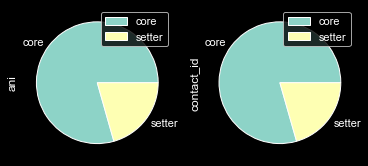

In [28]:
# Call origination: most of the calls were still first answered by the core team instead of the setter team
df_processed.groupby(by=['origination']).agg({'ani': lambda x: x.nunique(), 'contact_id': lambda x: x.nunique()}).plot.pie(subplots=True)

<a id='aht'>  </a>

# AHT

In [29]:
data = df_aht
# data = df_aht[(df_aht['date']>=datetime.date(2021, 11, 10))&(df_aht['date']<=datetime.date(2021, 11, 26))]

fig = go.Figure()

fig.add_trace(go.Violin(x=data['origination'][ data['is_converted'] == 0 ],
                        y=data['handle_time_min'][ data['is_converted'] == 0 ],
                        legendgroup='NotConv', scalegroup='NotConv', name='NotConv',
                        line_color='blue', points='all')
             )
fig.add_trace(go.Violin(x=data['origination'][ data['is_converted'] == 1 ],
                        y=data['handle_time_min'][ data['is_converted'] == 1 ],
                        legendgroup='ConvertedF', scalegroup='Converted', name='Converted',
                        line_color='orange', points='all')
             )

fig.update_traces(box_visible=True, meanline_visible=True)
fig.update_layout(violinmode='group', 
                  legend = dict(bgcolor = 'LightSteelBlue'),
                  title="AHT per Lead", 
                  xaxis_title="team", 
                  yaxis_title="handle time (mins)",)
fig.show()

### Observation

Setter team seems to be faster when it comes to filtering out non-converting customers.

In [31]:
df_tht = df_aht.groupby(by=['origination', 'is_converted']).agg({'lead_id': lambda x:x.nunique(),'handle_time_min': 'sum'}).reset_index()
df_tht
# total handle time for converting versus non-converting customers

origination  is_converted  lead_id  handle_time_min
0        core             0    25439         226654.3
1        core             1     2822         102099.6
2      setter             0     6836          51101.3
3      setter             1      496          17871.5

In [30]:
df_aht_avg = df_aht.groupby(by=['origination', 'is_converted']).agg({'lead_id': lambda x:x.nunique(),'handle_time_min': 'mean'}).reset_index()
df_aht_avg

origination  is_converted  lead_id  handle_time_min
0        core             0    25439         8.909717
1        core             1     2822        36.179872
2      setter             0     6836         7.475322
3      setter             1      496        36.031250

<a id='aht_ob'> </a>

### Observation

It takes about the same amount of time to convert customers, but the Setter team seems to be much faster when it comes to filtering out customers that did not convert.

In [32]:
print('AHT ratio for filtering non-converting customers (origination of setter/core): ' , round(df_aht_avg[(df_aht_avg['origination']=='setter')&(df_aht_avg['is_converted']==0)]['handle_time_min'].values[0]/df_aht_avg[(df_aht_avg['origination']=='core')&(df_aht_avg['is_converted']==0)]['handle_time_min'].values[0], 2))

AHT ratio for filtering non-converting customers (origination of setter/core):  0.84


In [33]:
print('AHT ratio to convert a customer (origination of setter/core): ' , round(df_aht_avg[(df_aht_avg['origination']=='setter')&(df_aht_avg['is_converted']==1)]['handle_time_min'].values[0]/df_aht_avg[(df_aht_avg['origination']=='core')&(df_aht_avg['is_converted']==1)]['handle_time_min'].values[0], 4))

AHT ratio to convert a customer (origination of setter/core):  0.9959


<a id='cpl'>  </a>


# CPL (Cost per Lead)

In [34]:
data = df_cpl
# data = df_cpl[(df_cpl['date']>=datetime.date(2021, 11, 10))&(df_cpl['date']<=datetime.date(2021, 11, 26))]

fig = go.Figure()

fig.add_trace(go.Violin(x=data['origination'][ data['is_converted'] == 0 ],
                        y=data['cost_per_lead'][ data['is_converted'] == 0 ],
                        legendgroup='NotConv', scalegroup='NotConv', name='NotConv',
                        line_color='blue', points='all')
             )
fig.add_trace(go.Violin(x=data['origination'][ data['is_converted'] == 1 ],
                        y=data['cost_per_lead'][ data['is_converted'] == 1 ],
                        legendgroup='ConvertedF', scalegroup='Converted', name='Converted',
                        line_color='orange', points='all')
             )

fig.update_traces(box_visible=True, meanline_visible=True)
fig.update_layout(violinmode='group', 
                  legend = dict(bgcolor = 'LightSteelBlue'),
                  title="Costs per Lead by Lead Origination and Conversion", 
                  xaxis_title="team", 
                  yaxis_title="Costs per Lead ($)")
fig.show()

### Observation

- Setter team costs less when it comes to filtering out non-converting customers.

In [35]:
df_cpl_ttl = df_cpl.groupby(by=['origination', 'is_converted']).agg({'lead_id': 'sum','call_cost': 'sum'}).reset_index()
df_cpl_ttl['avg_costs_call'] = df_cpl_ttl['call_cost']/df_cpl_ttl['lead_id']
df_cpl_ttl

origination  is_converted  lead_id    call_cost  avg_costs_call
0        core             0    25439  67566.96719        2.656039
1        core             1     2822  30450.37668       10.790353
2      setter             0     6836  13743.09729        2.010400
3      setter             1      496   5206.30395       10.496581

<a id='cost_per_lead'> </a>

### Observation

In terms of saving costs, Setter team is definitely a win!

In [36]:
print('Cost ratio for filtering non-converting customers (origination of setter/core): ' , round(df_cpl_ttl[(df_cpl_ttl['origination']=='setter')&(df_cpl_ttl['is_converted']==0)]['avg_costs_call'].values[0]/df_cpl_ttl[(df_cpl_ttl['origination']=='core')&(df_cpl_ttl['is_converted']==0)]['avg_costs_call'].values[0], 2))

Cost ratio for filtering non-converting customers (origination of setter/core):  0.76


In [37]:
print('Cost ratio to convert a customer (origination of setter/core): ' , round(df_cpl_ttl[(df_cpl_ttl['origination']=='setter')&(df_cpl_ttl['is_converted']==1)]['avg_costs_call'].values[0]/df_cpl_ttl[(df_cpl_ttl['origination']=='core')&(df_cpl_ttl['is_converted']==1)]['avg_costs_call'].values[0], 2))

Cost ratio to convert a customer (origination of setter/core):  0.97



# Weekday only Analysis

For all the analysis below, only weekdays after Nov 9th are included.


<a id='conv'>  </a>


# Conversion

__Converion calculation:__

`Core team`: # of policies sold with lead origination of 'core'/ # answered CPA calls (skill = 8410920, i.e., call origination is 'core') for that date. <br> 
`Setter team`: # of policies sold with lead origination of 'setter' / # of answered transferred CPA calls (skill = 10705109, i.e., call origination is 'setter') for that date. 

In [45]:
df_conv_agg = df_conv_gp.copy(deep=True)
df_conv_agg['weekday'] = pd.to_datetime(df_conv_agg['date']).dt.weekday

data = df_conv_agg[(df_conv_agg['date']>=datetime.date(2021, 11, 10)) & (~df_conv_agg['weekday'].isin([5,6]))]
fig = px.line(data, x="date", y="conversion", color="call_origination", markers=True)
fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'), title= 'Conversion')
fig.show()

In [ ]:
# Conversion per lead included in this as well, but a same lead could call in multiple times in different days
# df_conv_gp_check = df_conv_gp.groupby(by=['call_origination']).agg({'calls_count': 'sum', 'customers_count': 'sum', 'policies_count': 'sum'}).reset_index()
# df_conv_gp_check['conversion'] = df_conv_gp_check['policies_count']/df_conv_gp_check['calls_count']
# df_conv_gp_check['conversion_lead'] = df_conv_gp_check['policies_count']/df_conv_gp_check['customers_count']
# df_conv_gp_check

In [45]:
df_conv_gp_overall = df_conv_gp.groupby(by=['call_origination']).agg({'calls_count': 'sum', 'policies_count': 'sum'}).reset_index()
df_conv_gp_overall['conversion'] = df_conv_gp_overall['policies_count']/df_conv_gp_overall['calls_count']
df_conv_gp_overall

call_origination  calls_count  policies_count  conversion
0             core        29990            2746    0.091564
1           setter         3592             470    0.130846

In [46]:
conv_core_overall = df_conv_gp_overall[df_conv_gp_overall['call_origination']=='core']['conversion'].values[0]
conv_setter_overall = df_conv_gp_overall[df_conv_gp_overall['call_origination']=='setter']['conversion'].values[0]
print('The overall conversion rate for the core team is: ', round(conv_core_overall, 4), '; \n the overall conversion rate for the setter team is: ', round(conv_setter_overall, 4), '.')
print('Conversion ratio between the two teams (origination of setter/core): ' ,  
      round(conv_setter_overall/conv_core_overall, 2))

The overall conversion rate for the core team is:  0.0916 ; 
 the overall conversion rate for the setter team is:  0.1308 .
Conversion ratio between the two teams (origination of setter/core):  1.43


__Setter team's conversion is higher by a good amount!__

<a id='issue_rate'>  </a>

# Issue Rate

Issue rate = ( # of revenue-eligible policy ) / (# of sold policy)

In [47]:
df_issuse_rate = df_conv_gp.groupby(['call_origination']).agg({'issued_count': 'sum', 'policies_count':'sum'}).reset_index()
df_issuse_rate['issue_rate'] = df_issuse_rate['issued_count'] / df_issuse_rate['policies_count']
df_issuse_rate

call_origination  issued_count  policies_count  issue_rate
0             core        1581.0            2746    0.575747
1           setter         274.0             470    0.582979

In [48]:
df_conv_agg = df_conv_gp.copy(deep=True)
df_conv_agg['weekday'] = pd.to_datetime(df_conv_agg['date']).dt.weekday

data = df_conv_agg[(df_conv_agg['date']>=datetime.date(2021, 11, 10)) & (~df_conv_agg['weekday'].isin([5,6]))]
fig = px.line(data, x="date", y="issued_rate", color="call_origination", markers=True, hover_data=[data['issued_count'], data['policies_count']])
fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'), title= 'issued_rate')
fig.show()

__Observations:__ <br>

Issue ratae is about the same across the two teams. 

<a id='gppc'>  </a>


# GPPC

In [112]:
# Weekday only GPPC
data = df_conv_gp
data['weekday'] = pd.to_datetime(data['date']).dt.weekday
data = data[(data['date']>=datetime.date(2021, 11, 10)) & (~data['weekday'].isin([5,6]))]

fig = px.line(data, x="date", y="gp_pc", color="call_origination", markers=True, hover_data=[data['calls_count']])

fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'))
fig.show()


# GP Lift and Incremental GP Lift
gp_gain = (gppc_setter - gppc_core) * answered_transfers_from_setter

In [127]:
data = df_conv_gp.copy(deep=True)
data['weekday'] = pd.to_datetime(data['date']).dt.weekday
data = data[(data['date']>=datetime.date(2021, 11, 10)) & (~data['weekday'].isin([5,6]))]
data_df = pd.DataFrame(columns=['date', 'calls_count', 'gppc_diff', 'gp_gain'])
gppc_diff = data[data['call_origination']=='setter']['gp_pc'].values - data[data['call_origination']=='core']['gp_pc'].values
sett_ans_trans = data[data['call_origination']=='setter']['calls_count'].values
data_df['date'] = data['date'].unique()
data_df['calls_count'] = sett_ans_trans
data_df['gppc_diff'] = gppc_diff
data_df['gp_gain'] = gppc_diff*sett_ans_trans
print('Total GP lift by running the Setter team during this period (Nov 10 - Dec 7, weekdays): $', round(data_df['gp_gain'].sum()))
print('There are',  data_df['calls_count'].sum() , 'calls (from new customers) in this period answered by the Setter team. ')
print('That means CL is making an extra of $', round(data_df['gp_gain'].sum() / data_df['calls_count'].sum(), 2), 'per call. ')

data_df['gp_diff_cumsum'] = data_df['gp_gain'].cumsum()
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_df['date'], y=data_df['gp_gain'], name='GP_diff', line=dict(color='firebrick', width=3)))
fig.add_trace(go.Scatter(x=data_df['date'], y=data_df['gp_diff_cumsum'], name='GP_cumsum', line=dict(color='royalblue', width=3)))

fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'),
                  title='Difference in GP & the Incremental Sum',
                  xaxis_title='Date',
                  yaxis_title='GP ($)')
fig.show()

Total GP lift by running the Setter team during this period (Nov 10 - Dec 7, weekdays): $ 50459
There are 3452 calls (from new customers) in this period answered by the Setter team. 
That means CL is making an extra of $ 14.62 per call. 


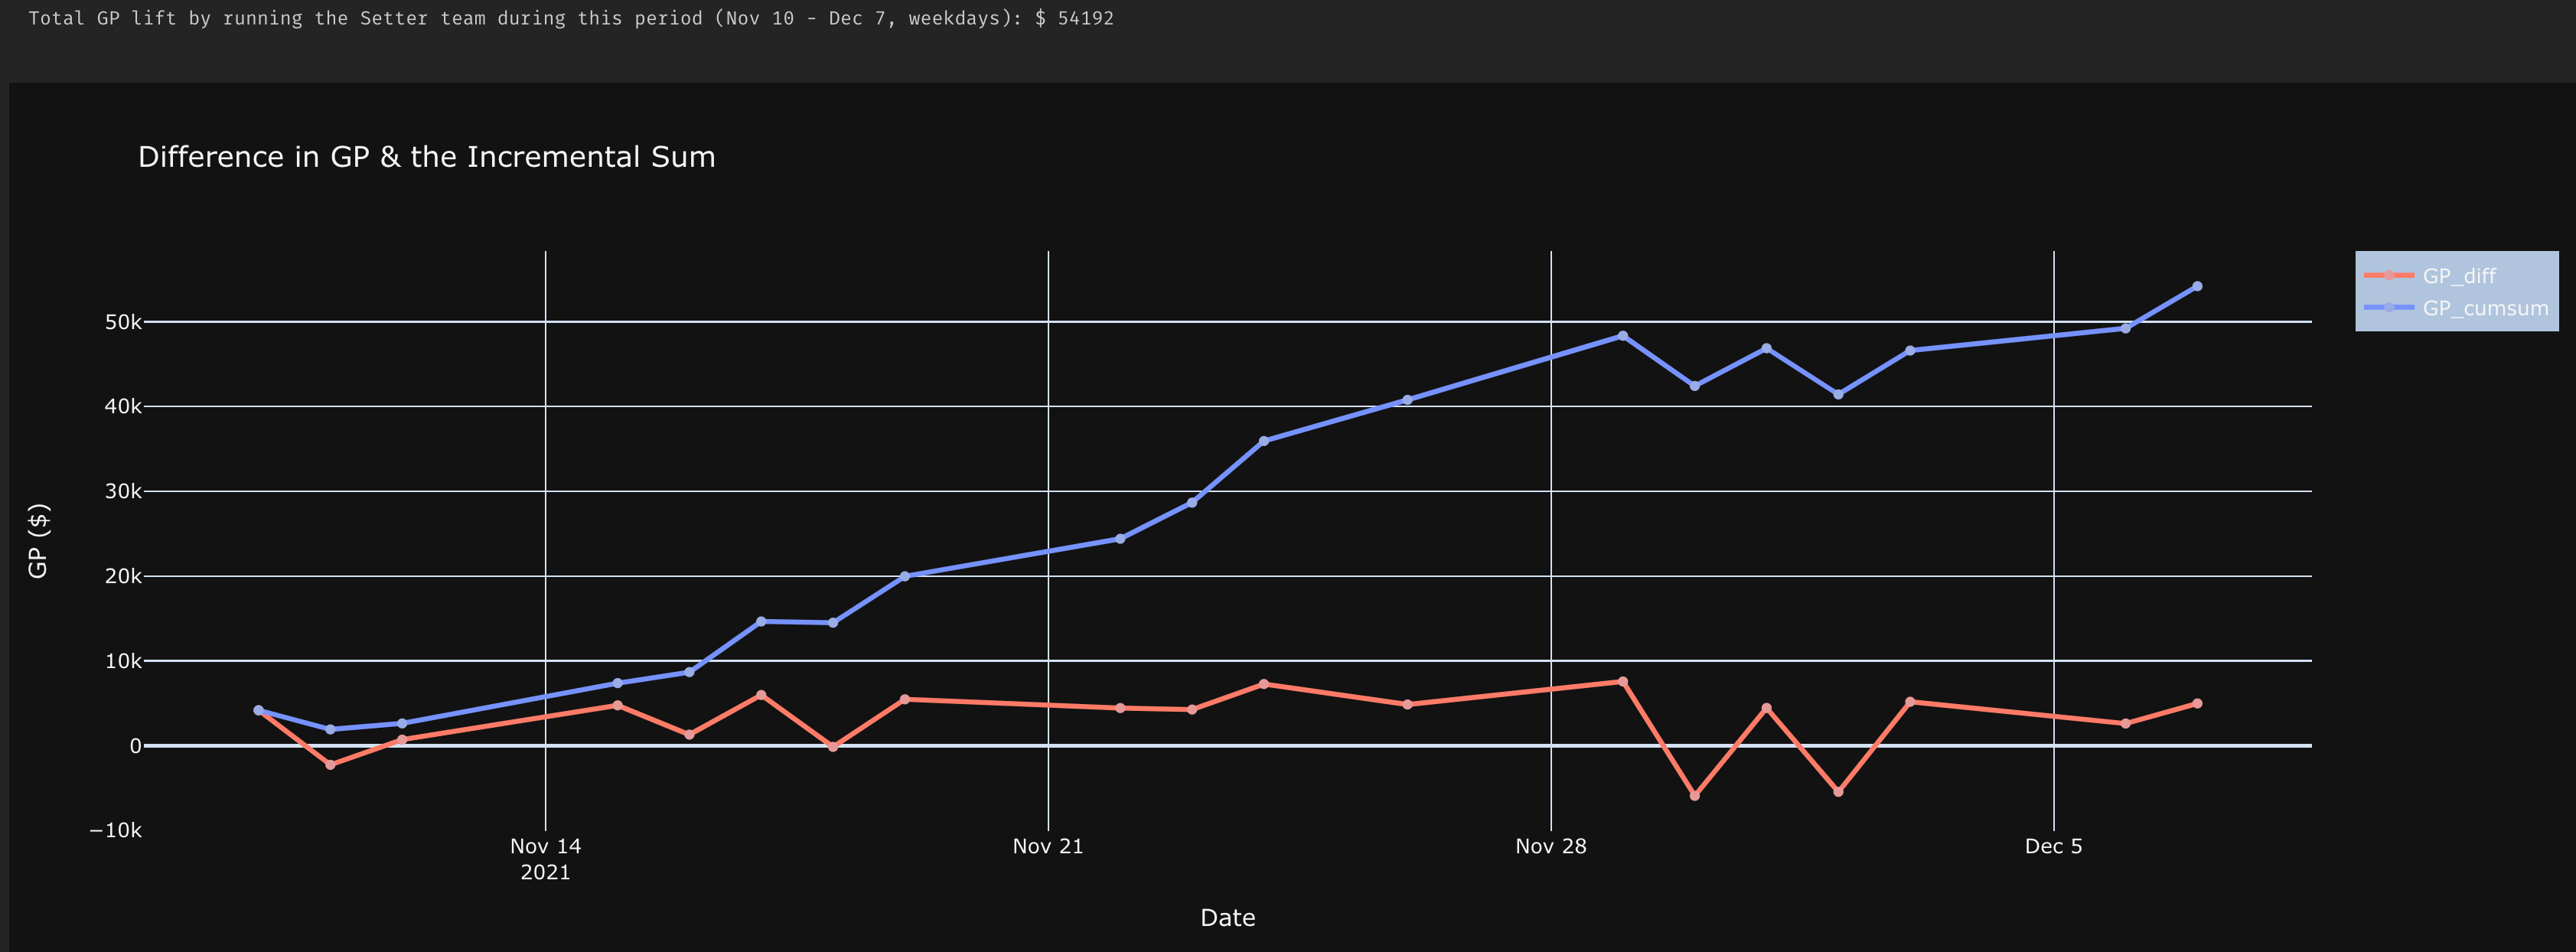

In [68]:
from IPython import display
display.Image("./PreviousRun.png")
# Some policies have been deleted! 

In [69]:
df_calls_n = df_processed.copy(deep=True)
df_calls_n.loc[(df_calls_n['title']=='Lead Generation')&(df_calls_n['team']=='Insurance Allocation'), 'agent_cost'] = 5  # settter agents
df_calls_n['call_cost'] = round(df_calls_n['agent_cost']/60, 4) * df_calls_n['handle_time_min']

[df_calls_ans_n, df_setter_nat_n] = agg_calls(df_calls_n)
df_conv_gp_n = conv_gp_cal(df_calls_ans_n, df_policies_agg, df_setter_nat_n)

In [70]:
# If all Setters cost only $5
data = df_conv_gp_n.copy(deep=True)
data['weekday'] = pd.to_datetime(data['date']).dt.weekday
data = data[(data['date']>=datetime.date(2021, 11, 10)) & (~data['weekday'].isin([5,6]))]
data_df = pd.DataFrame(columns=['date', 'calls_count', 'gppc_diff', 'gp_gain'])
gppc_diff = data[data['call_origination']=='setter']['gp_pc'].values - data[data['call_origination']=='core']['gp_pc'].values
sett_ans_trans = data[data['call_origination']=='setter']['calls_count'].values
data_df['date'] = data['date'].unique()
data_df['calls_count'] = sett_ans_trans
data_df['gppc_diff'] = gppc_diff
data_df['gp_gain'] = gppc_diff*sett_ans_trans
print('Total GP lift by running the Setter team during this period (Nov 10 - Dec 7, weekdays) if all Setter team agents cost only $5: $', round(data_df['gp_gain'].sum()))

data_df['gp_diff_cumsum'] = data_df['gp_gain'].cumsum()
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_df['date'], y=data_df['gp_gain'], name='GP_diff', line=dict(color='firebrick', width=3)))
fig.add_trace(go.Scatter(x=data_df['date'], y=data_df['gp_diff_cumsum'], name='GP_cumsum', line=dict(color='royalblue', width=3)))

fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'),
                  title='Difference in GP & the Incremental Sum',
                  xaxis_title='Date',
                  yaxis_title='GP ($)')
fig.show()

Total GP lift by running the Setter team during this period (Nov 10 - Dec 7, weekdays) if all Setter team agents cost only $5: $ 52502


In [85]:
# Number of Setter agents active each day
df_setters = df_1[(df_1['title']=='Lead Generation')&(df_1['team']=='Insurance Allocation')].groupby('date').agg({'cd_agent_id': lambda x:x.nunique()}).reset_index()
df_setters.rename(columns={'cd_agent_id': 'setter_counts'}, inplace=True)
df_setters['weekday'] = pd.to_datetime(df_setters['date']).dt.weekday
df_setters
df_setters_w = df_setters[(df_setters['date']>=datetime.date(2021, 11, 15)) & (~df_setters['weekday'].isin([5,6]))]
print('An average of ', df_setters_w['setter_counts'].mean(), ' Setter agents worked during the weekdays from Nov 15 to Dec 7; that is ', df_setters_w['date'].nunique(), 'weekdays')

fig = px.line(df_setters_w, x="date", y="setter_counts", markers=True)

fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'), title='Number of Setter Agents Working Each Weekday (Nov 15 - Dec 7, 2021)')
fig.show()

An average of  7.0625  Setter agents worked during the weekdays from Nov 15 to Dec 7; that is  16 weekdays


# TL; DR
- The Setter team costs slightly less than the core team to convert a customer. [AHT](#aht_ob) & [CPL](#cost_per_lead). 
- The Setter team is much more efficient at filtering non-converting customers, only costs __0.76__ time that of the core team.
- Setter team has a much higher conversion (__13.08%__ compared to __9.15%__ for the core team). 
- [Issue rate](#issue_rate) is about the same across the two teams. 
- By running the MED Setter team, the cummulative GP gain during the period of the project (Nov 10 - Dec 7, weekdays) is __~ 50k__, that is an extra of __14.6__ per call! 

__Overall, running a Setter team has been successful.__